# MEC_51057_EP Energy Project, Jacobo Arroyave Restrepo & Christian Schlüter Prieto


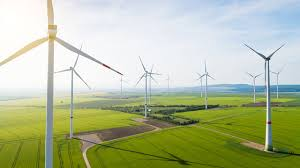

The goal of this notebook is to predict wind **capacity factors (CFs)** across different regions of France using various **machine learning (ML)** techniques. This notebook aims to provide a systematic approach to selecting features and understanding their impact on the predictive performance of wind CFs in France.  

The data used includes:  
- **CF data (2014-2022) across continental regions in France**  
- **Weather data (2010-2019) across continental regions in France**  

The combined dataset (i.e., the overlapping period between CF and weather data) spans from **2014** to  **2019**.  

The analysis workflow will include:  

0. **Import Libraries**
1. **Data Pre-Processing**  
    - 1.1 CF Data  
    - 1.2 Weather Data  
    - 1.3 Combined Data

2. **Feature Selection**: We add features which we deem to be relevant, such as CF from the previous Month. Then we use 3 different methods to score the feature importance in each region and we take this results and average them to get a **Global Feature Importance**. This tells us what features are the most important on average across all reagions.

3. **Model Evaluation**: Assess how the model's R² score changes when adding features from the best to worst according to their importance. With this result, the impact of which features and the amount of them on the score of different ML models can be examined.

4. **Discussion**





## Import libraries

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


## Data Pre-Processing

### Wind CF Data

In [123]:
#drive.mount('/content/drive')
file = 'reseaux_energies_capacityfactor_wind-onshore.csv'
# We read the csv file using pandas
cf_df = pd.read_csv(file)
# We set the column "time" as a datetime type of data and then we make that column the index
cf_df['time'] = pd.to_datetime(cf_df['time'])
cf_df = cf_df.set_index('time')
# We rename some of the columns so they are the same as the weather file of data
cf_df.rename(columns={"Île-de-France": "Ile-de-France"},inplace=True)
cf_df.rename(columns={"Pays de la Loire": "Pays-de-la-Loire"},inplace=True)
cf_df.rename(columns={"Provence-Alpes-Côte d'Azur": "PACA"},inplace=True)
# cf_df.head()



In [124]:
# Check for missing data
cf_df.isnull().any().any()

np.False_

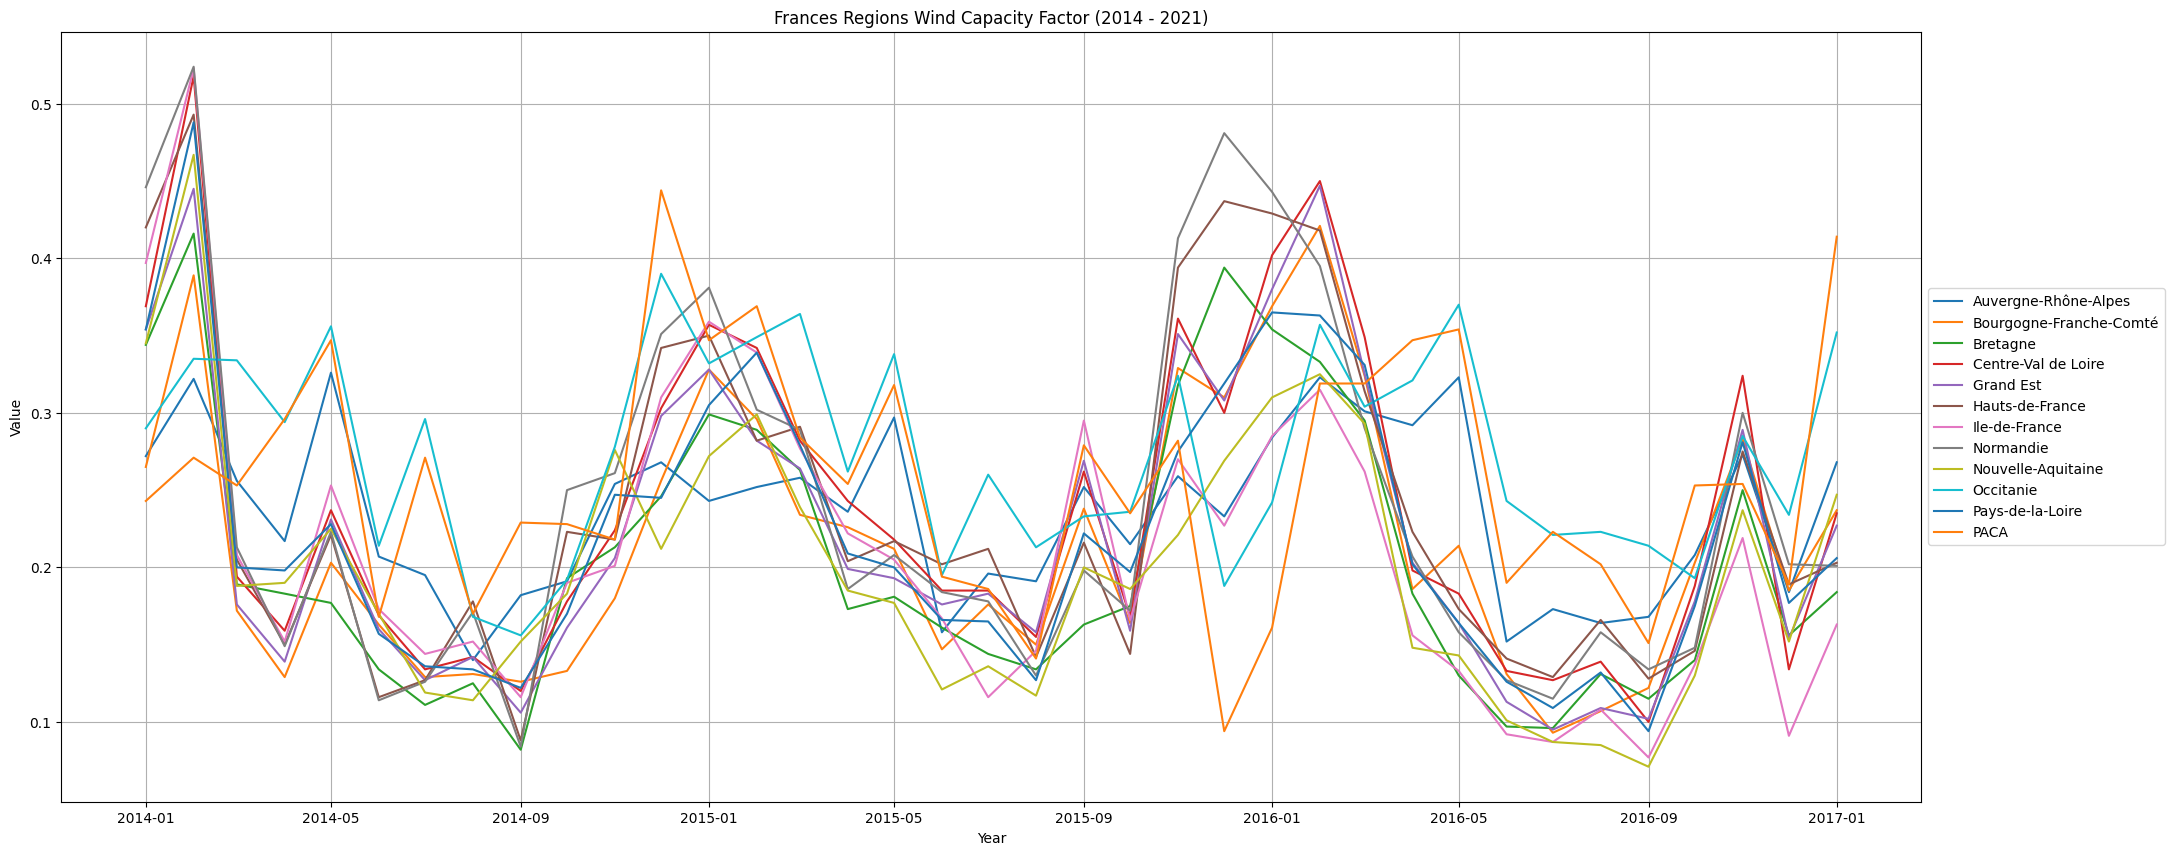

In [125]:
# Visualize data
plt.figure(figsize=(24, 10))

plt.plot(cf_df.loc[:"2017-01-01"])

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Frances Regions Wind Capacity Factor (2014 - 2021)')
plt.legend(cf_df.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

**We see a strong seasonal behaviour. High values during winter and lower values during summer, just like most of the weather data that we will see further. Therefore, analysing the anomalies and using them as inputs would be a natural approach for our project.**

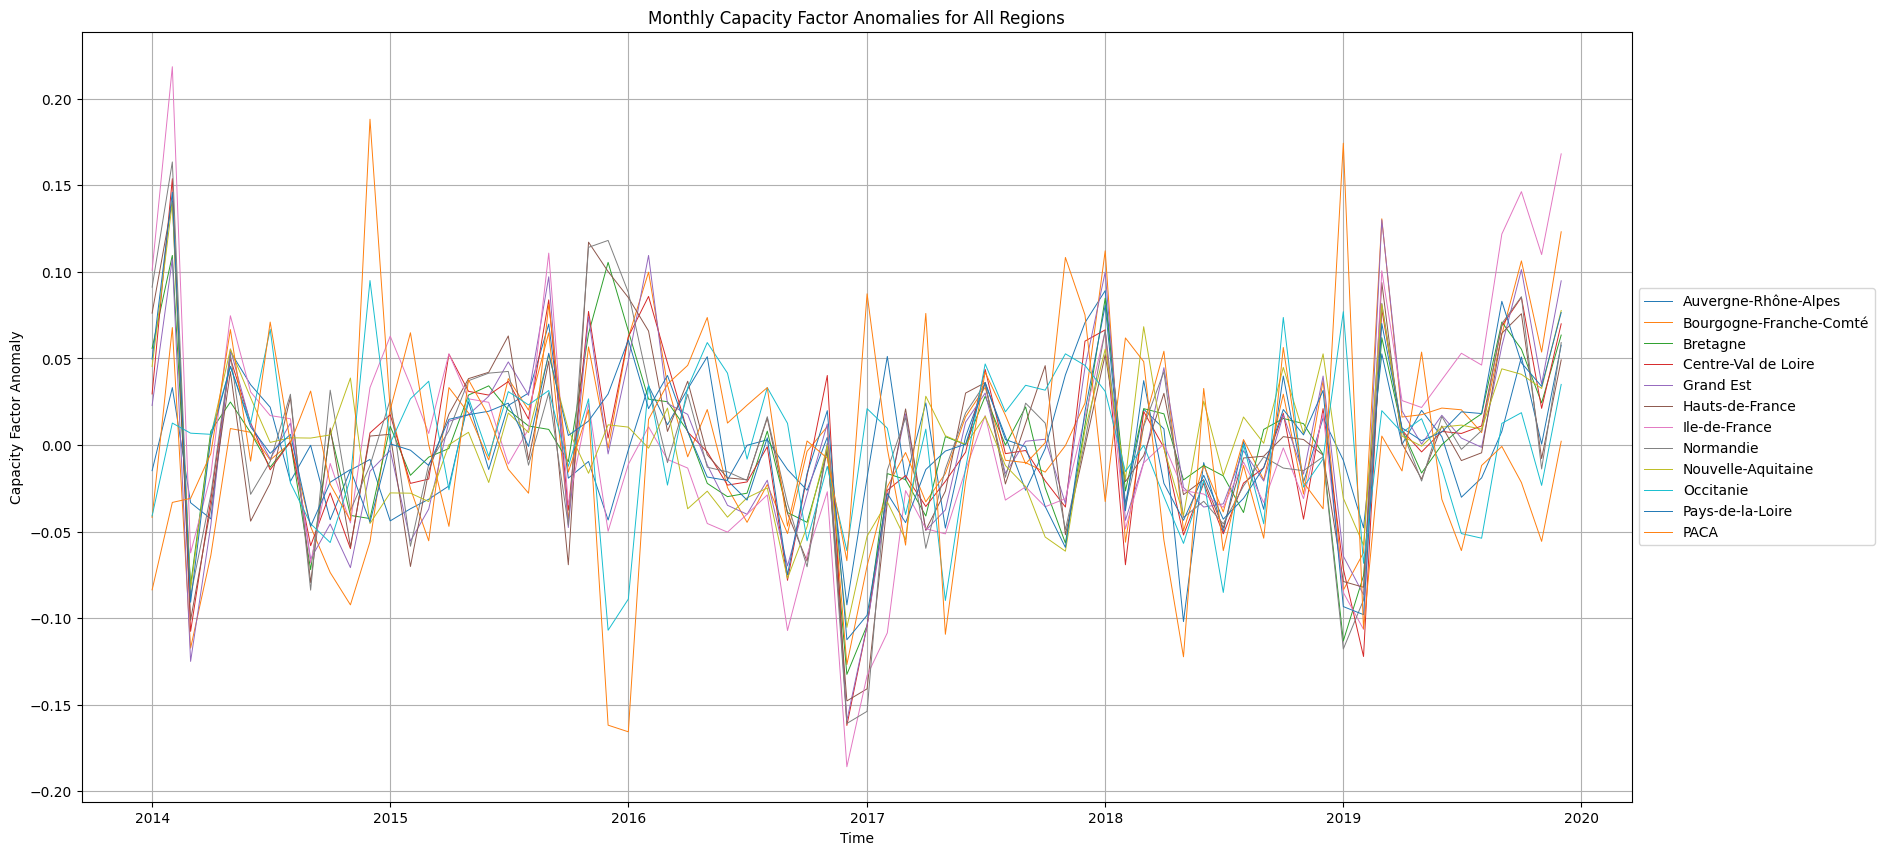

In [126]:
# We calculate the anomalies
cutoff = "2019-12-01"  # We dont have weather data for 2020 and further. We do the cutoff here, as data taken after 2019 will impact the monthly mean,
# and when compared to weather variables, we will have influences of periods
# that our model will not have seen.
region_dfs = {}

plt.figure(figsize=(20,10))

for region in cf_df.columns:
    # 1. Select only pre-2020 data for climatology
    cf_pre2019 = cf_df.loc[:cutoff, region]

    # 2. Compute monthly means from pre-2020 period
    monthly_mean = cf_pre2019.groupby(cf_pre2019.index.month).mean()

    # 3. Compute anomalies for the full series
    # This looks up the month of the row of data that we are working on and
    # substracts the corresponding monthly mean
    cf_anomalies = cf_pre2019 - cf_pre2019.index.month.map(monthly_mean)

    # 4. Store each region as a dataframe
    region_dfs[region] = pd.DataFrame({
        "CF": cf_anomalies
    })

    # 5. Plot
    plt.plot(cf_anomalies.index, cf_anomalies, linewidth=0.7, label=region)



plt.title("Monthly Capacity Factor Anomalies for All Regions")
plt.xlabel("Time")
plt.ylabel("Capacity Factor Anomaly")
plt.grid(True)

# We put the legend on the right of our graph
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**It can be seen still some similar behaviour between regions in the CF anomalies, but now the seasonal behavior is not so evident**

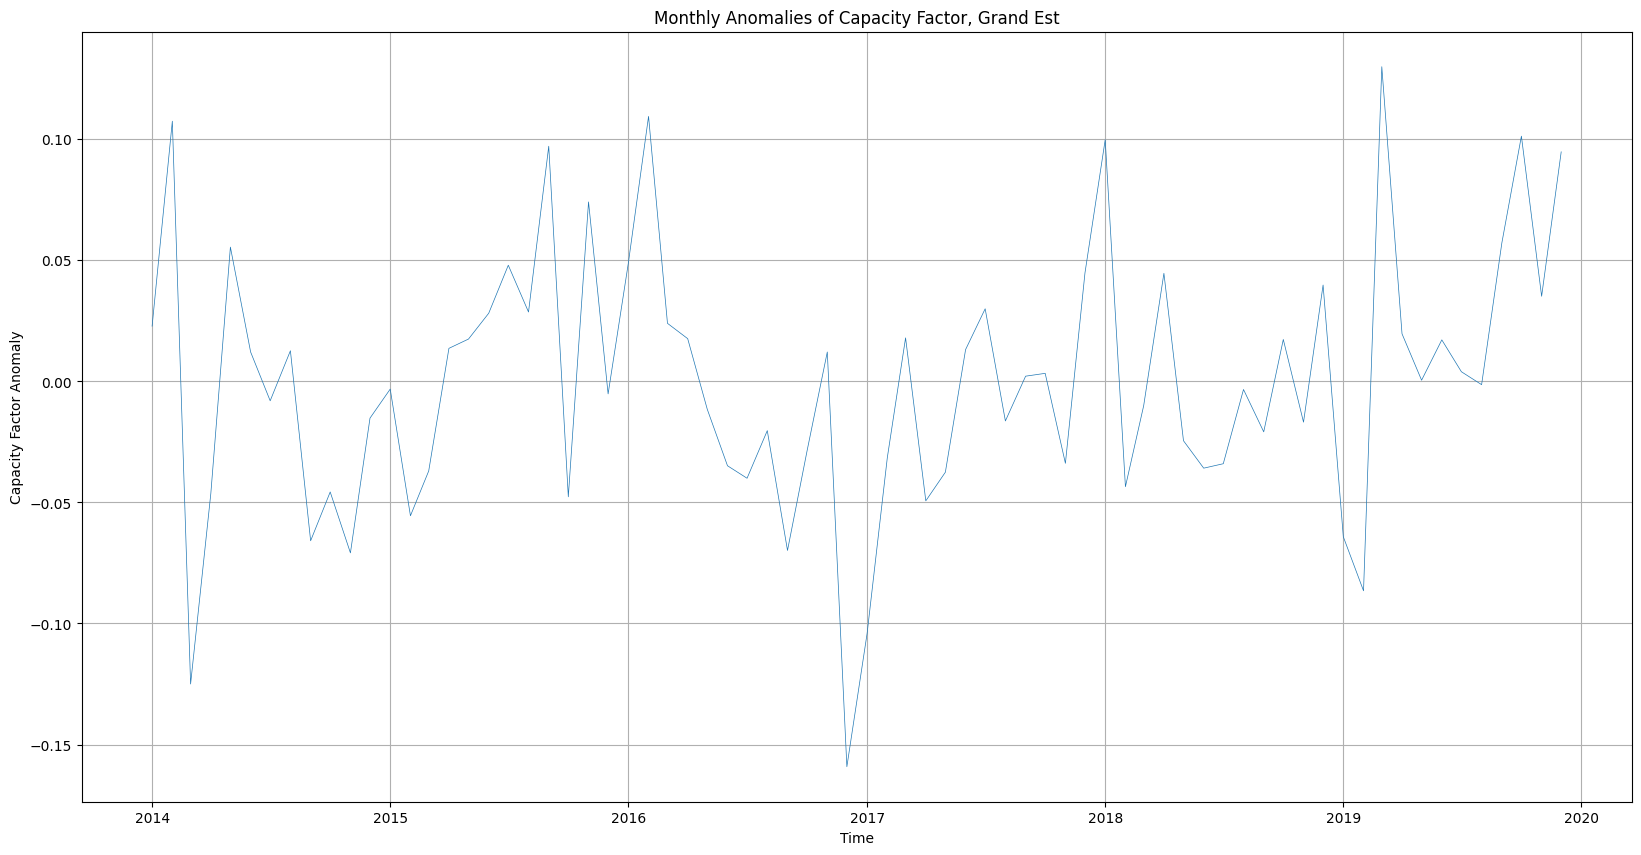

In [127]:
# Choose which region you want to see the CF anomalies for, to visualize informations after the results.
region = 'Grand Est'

# Plot
plt.figure(figsize=(20,10))
plt.plot(region_dfs[region].index, region_dfs[region], linewidth=0.5)
plt.title(f"Monthly Anomalies of Capacity Factor, {region}")
plt.xlabel("Time")
plt.ylabel("Capacity Factor Anomaly")
plt.grid(True)
plt.show()


### Weather Data

In [128]:
#  Load the mask which helps us associate each pair of coordinates to one of the eleven continental France regions.
mask_ds = xr.open_dataset("mask_datagouv_french_regions_merra2_Nx_France.nc")
mask = mask_ds["mask"]
regions = mask_ds["region"]
region_index = mask_ds["region_index"]

# List of NetCDF files with weather data (2010-2019) downloaded from the MERRA2 database
file_paths = [
    "merra2_area_selection_output_height_500_merra2_2010-2019.nc",
    "merra2_area_selection_output_meridional_wind_merra2_2010-2019.nc",
    "merra2_area_selection_output_surface_density_merra2_2010-2019.nc",
    "merra2_area_selection_output_surface_downward_radiation_merra2_2010-2019.nc",
    "merra2_area_selection_output_surface_specific_humidity_merra2_2010-2019.nc",
    "merra2_area_selection_output_surface_temperature_merra2_2010-2019.nc",
    "merra2_area_selection_output_upper_meridional_wind_merra2_2010-2019.nc",
    "merra2_area_selection_output_upper_zonal_wind_merra2_2010-2019.nc",
    "merra2_area_selection_output_zonal_wind_merra2_2010-2019.nc"
]

# Container for all regional time series
all_regions_df = []

# Loop over all files, for example the first is the h500
for file_path in file_paths:
    ds = xr.open_dataset(file_path)

    # Loop over all variables in this dataset (skip coordinates like latitude, longitude and time)
    for var_name in ds.data_vars: #this is to make sure that we load all the data and is checking if we maybe have more than one data variable in one file
        var_data = ds[var_name]

        regional_ts = {} # Initializes the place holder for the data that is about to come
        # Loop over the 11 regions
        for i, region_name in enumerate(regions.values):
            # Mask for this region, boolean to know that the mask is equal to
            # the region index (so the lat and lon correspond to the actual
            # region)

            region_mask = (mask == region_index[i])

            # Compute spatial mean for the region we are looping in at every time step, because we had multiple grid
            #points and we wanted to get a global average for the region, as we are trying
            #to match it with the CP, that is given for every region and not in the 205 data points given here
            regional_mean = var_data.where(region_mask, drop=False).mean(dim="stacked_dim") #Drop the ones where the mask is not equal to index

            # Store with region name
            regional_ts[str(region_name)] = regional_mean.values

        # Convert to DataFrame (time as index)
        w_df = pd.DataFrame(
            regional_ts,
            index=pd.to_datetime(var_data.time.values)
        )

        # Add columns to identify variable and source file
        w_df["variable"] = var_name
        w_df["file"] = file_path.split("/")[-1]

        # Append to master list
        all_regions_df.append(w_df)

    # Close dataset to free memory
    ds.close()

# Concatenate all regional time series, basically resets the index and moves time to a column
all_regions_df = pd.concat(all_regions_df).reset_index().rename(columns={"index": "time"})



**We can visualize the mean of one of the variables using Cartopy, to understand better how the data from MERRA2 is stacked in 205 different points along France.**

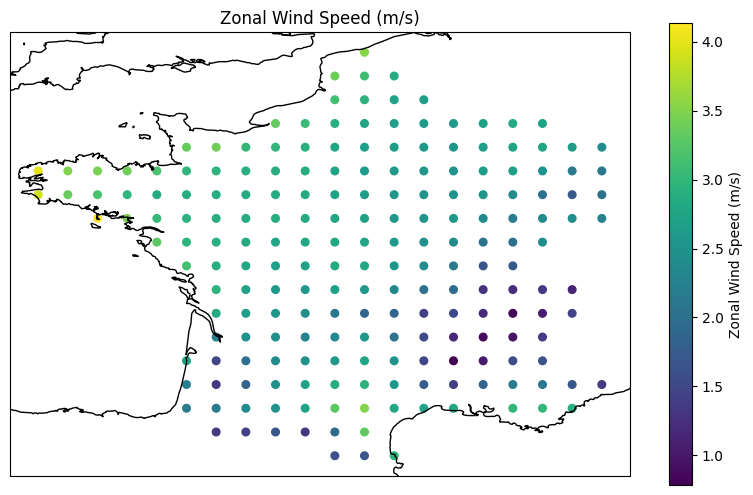

In [129]:
#We load the zonal wind data set individually as an example, this way is easier to access for this visualization
ds_temp = xr.load_dataset("merra2_area_selection_output_zonal_wind_merra2_2010-2019.nc")
# We take absolute value to stop positive values to cancel with positive ones.
da = abs(ds_temp["zonal_wind"])
# We compute the mean across the 10 years of measurements for the 205 points.
var_mean = da.mean(dim="time")
# Plot mean
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

sc = ax.scatter(
    ds_temp.lon.values, #x axis
    ds_temp.lat.values, #y axis
    c=var_mean.values,   # use the mean values
    s=30, #marker size
    cmap="viridis",      # different colormap for mean
    transform=ccrs.PlateCarree()
)

ax.coastlines()
plt.colorbar(sc, label="Zonal Wind Speed (m/s)")
plt.title("Zonal Wind Speed (m/s)")
plt.show()

**From this graph we can already observe a higher zonal wind mean for the northern part of France, which would intuitively imply a higher Capacity Factor**

In [130]:
# Cut off data so that it matches the timeframe of the CF data, starting point in 2014 onward.

df_A = all_regions_df
df_A = df_A[df_A["time"] >= "2014-01-01"]

# Name the regions present in our dataset

regions = [
    "Grand Est", "Nouvelle-Aquitaine", "Auvergne-Rhône-Alpes",
    "Bourgogne-Franche-Comté", "Bretagne", "Centre-Val de Loire",
    "Ile-de-France", "Occitanie", "Hauts-de-France", "Normandie",
    "Pays-de-la-Loire", "PACA"
]

# Name the wind variables, to later compute the absolute value to prevent us from canceling positive with negative values

wind_vars = [
    "meridional_wind",
    "upper_meridional_wind",
    "upper_zonal_wind",
    "zonal_wind"
]
region_weather_dfs = {}  # store results here
region_weather_anomalies = {}

for region in regions:

    # 1. Select only time, the region we are looping in's weather values, and
    # the variable name
    w_df = df_A[['time', region, 'variable']]

    # 2. Pivot stacked variable format into a  wide format
    df_wide = w_df.pivot(index='time', columns='variable', values=region)

    # 3. Convert the selected wind variables to absolute value, using the wind_vars we created before
    for var in wind_vars:
        if var in df_wide.columns:
            df_wide[var] = df_wide[var].abs()


    # 4. Make the column "time" our index
    df_wide = df_wide.reset_index().set_index('time')

    # 5. Resampling this to monthly data

    df_wide = df_wide.resample("MS").mean()

    # 6. Store dataframe in a dictionary of multiple dataframes

    region_weather_dfs[region] = df_wide

    # 7. We compute the mean of all the months from the dataset we are looping in

    df_anomalies = df_wide.groupby(df_wide.index.month).transform(lambda x: x - x.mean())
    region_weather_anomalies[region] = df_anomalies


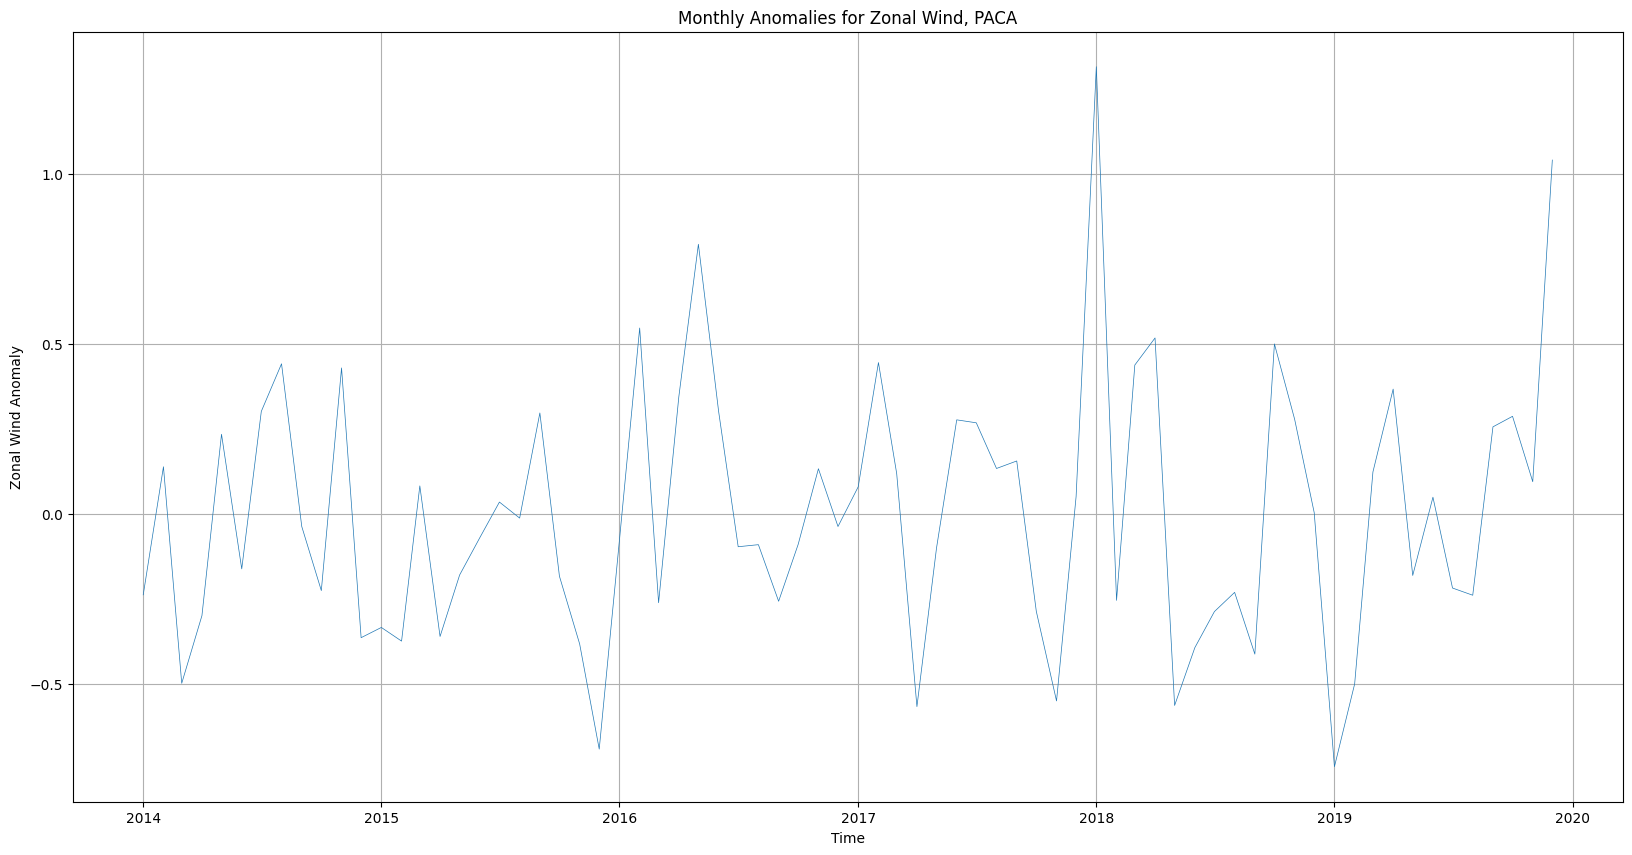

In [131]:
# Choose which region you want to see the CF anomalies for
region = 'PACA' # they are: Grand Est, Nouvelle-Aquitaine, Auvergne-Rhône-Alpes, Bourgogne-Franche-Comté
# Bretagne, Centre-Val de Loire, Ile-de-France, Occitanie, Hauts-de-France, Normandie, Pays-de-la-Loire, PACA
weather_var = 'zonal_wind' # they are: height_500, meridional_wind, surface_density, surface_downward_radiation,
# Plot
plt.figure(figsize=(20,10))
plt.plot(region_weather_anomalies[region][weather_var].index, region_weather_anomalies[region][weather_var], linewidth=0.5)
plt.title(f"Monthly Anomalies for Zonal Wind, {region}")
plt.xlabel("Time")
plt.ylabel("Zonal Wind Anomaly")
plt.grid(True)
plt.show()

**We can't clearly see a seasonal pattern here. Because of this, we can try to identify a relationship between the weather data and the capacity factor that is not directly influenced by the seasonality**

### Combined CF and Weather


In [132]:
for region_name, wdf_anom in region_weather_anomalies.items():

    # capacity factor dataframe for the same region
    cf_df = region_dfs[region_name]

    # horizontally concatenate on time index
    region_weather_anomalies[region_name] = pd.concat(
        [wdf_anom, cf_df], axis=1
    )

clean_data = region_weather_anomalies

## Feature Selection

**We add the previous month as a feature**

In [133]:
for region_name, df in clean_data.items():
    df["CF M-1"] = df["CF"].shift(1)
    df.dropna(subset=["CF M-1"], inplace=True)


**We create the vector X for every region**

In [134]:
X_0 = {}
for region_name, df in clean_data.items():
    X_0[region_name] = df.drop(columns=["CF"])

y_0 = {}
# We create the vector Y for every region
for region_name, df in clean_data.items():
    # Keep only the capacity factor column
    y_0[region_name] = df[["CF"]].copy()


**We want to loop through all the regions, do KBest, Ensemble and Wrapper method and check which are the most important features for each one of them. Then, with the score that each features has when looping through each region, rank and select the features that our model should use.**

**By doing this, we can use more data, even if it just for chosing our best features.**

In [135]:

def compute_feature_scores_region(weather_df, cf_series, k=3):
    """
    weather_df : dataframe containing ONLY weather features for 1 region
    cf_series  : capacity factor Series for the same region
    k : number of selected features (for KBest/RFE)
    """

    X = weather_df.values
    Y = cf_series.values
    feature_names = weather_df.columns

    results = {}

    # 1. Filter Method
    # We check if the k is not larger than the number of features
    kbest = SelectKBest(score_func=f_regression, k=min(k, X.shape[1]))
    kbest.fit(X, Y)
    results["SelectKBest"] = kbest.scores_

    # 2. Embedded Method (Random Forest)
    rf = RandomForestRegressor(n_estimators=300, random_state=0)
    rf.fit(X, Y)
    results["RandomForest"] = rf.feature_importances_

    # 3. Wrapper Method (RFE using Linear Regression)
    lr = LinearRegression()
    rfe = RFE(lr, n_features_to_select=min(k, X.shape[1]))
    rfe.fit(X, Y)
    results["RFE"] = -rfe.ranking_     # here we need to invert so the higher in the ranking is the more important

    region_df = pd.DataFrame(results, index=feature_names)

    return region_df

We use the function we just created to get all the results for all the zones

In [149]:
all_results = []
for region_name, wdf in X_0.items():

  cf_series = y_0[region_name]
  if isinstance(cf_series, pd.DataFrame):
      cf_series = cf_series.squeeze()  # single-column DF → Series

  region_scores = compute_feature_scores_region(wdf, cf_series)
  region_scores["Region"] = region_name

  all_results.append(region_scores)

  all_results_df = pd.concat(all_results)

We obtain a dataframe with the score of each method and the region as a column, the index being the weather variables. Now we will create a function that takes the output of compute_feature_scores_region() and converts all columns to comparable ranks, taking into account that KBest, Embedded and Wrapper Method return scores in different orders of magnitude.

In [137]:
def normalize_feature_scores(region_df):

    ranked = pd.DataFrame(index=region_df.index)

    for col in region_df.columns[:-1]:  # exclude 'Region'
        scores = region_df[col]

        # Higher score → better rank
        ranked[col] = scores.rank(method="average", ascending=False)

    return ranked


We use the function we just created on our data

In [138]:
all_results_ranked = []

for region_name, wdf in X_0.items():

    cf_series = y_0[region_name]

    # Ensure y is 1D to avoid DataConversionWarning
    if isinstance(cf_series, pd.DataFrame):
        cf_series = cf_series.squeeze()
    else:
        cf_series = np.ravel(cf_series)

    region_scores = compute_feature_scores_region(wdf, cf_series)

    region_scores["Region"] = region_name

    ranked_scores = normalize_feature_scores(region_scores)
    ranked_scores["Region"] = region_name

    all_results_ranked.append(ranked_scores)

ranked_df = pd.concat(all_results_ranked)


The result we get is a dataframe, just like the previous one, but in this case we do not have the scores but rankings from 1 -10 (the best to the worst feature) in the columns.

Now we will compute the mean rank between all the regions, so we can see on average which are the best features to predict the capacity factor throughout the regions

In [139]:
global_ranking = (
    ranked_df
    .groupby(ranked_df.index) # The weather variables are the index, that is why we can group them by the index
    .mean(numeric_only=True)   # mean rank across regions
    .sort_values(by=["SelectKBest", "RandomForest", "RFE"])
)

global_ranking["mean_rank"] = global_ranking.mean(axis=1)
global_ranking = global_ranking.sort_values("mean_rank")

Global ranking is a data frame with the index being the weather variables and the columns the three feature selection methods. Now we have the score for them using the mean across regions.

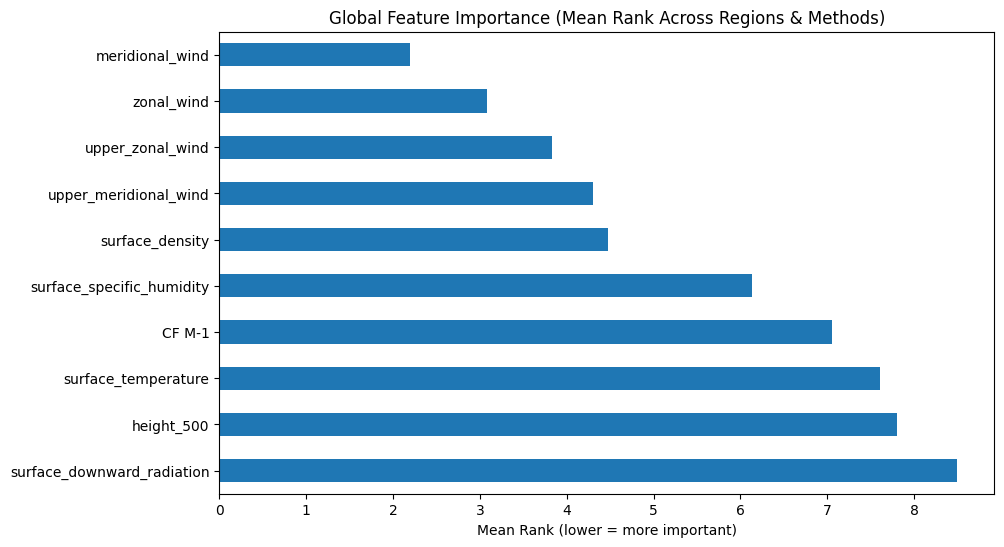

In [140]:
# Now we will compute the average between the ranking given by the three feature selection methods, and plot them to decide which are the features that better predict the CF based on the weather.
global_rank = (
    ranked_df
    .drop(columns="Region")
    .mean(axis=1)
    .groupby(level=0)
    .mean()
    .sort_values()
)

plt.figure(figsize=(10, 6))
global_rank.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Global Feature Importance (Mean Rank Across Regions & Methods)")
plt.xlabel("Mean Rank (lower = more important)")
plt.show()


## Model Evaluation

Now let's see how accurately a Linear Model would predict the values for the capacity factor in one region (Ile-de-France), by only using the top four features (the ones associated with wind, in our case).

In [141]:
# Take the top 4 features automatically
top_features_global = global_rank.sort_values().head(4).index.tolist()
region = 'Ile-de-France'
X = X_0[region][top_features_global].values  # features
y = y_0[region].values          # target: capacity factor

Let's now implement K-Fold for Cross Validation.

In [142]:
# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV


Train Model

In [143]:
# Example model
model = LinearRegression()

# Evaluate with cross-validation
scores = cross_val_score(model, X, y, cv=kf, scoring='r2')  # R^2 as metric

print("R^2 scores for each fold:", scores)
print("Mean R^2:", scores.mean())


R^2 scores for each fold: [0.71646683 0.91593871 0.54673761 0.6424335  0.33768647]
Mean R^2: 0.6318526242299465


We can see that, by only using four features the R2 has a strong variability. Maybe we can try to add more features and implement a different model (Random Forest

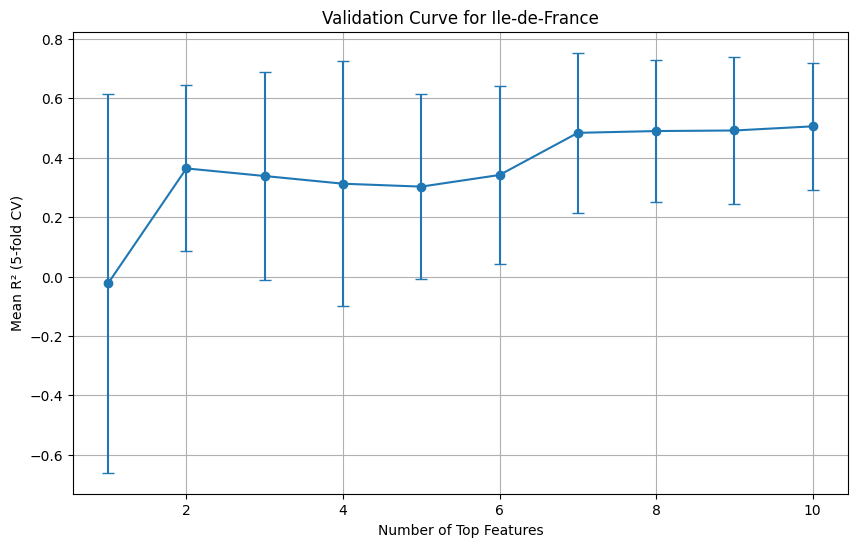

In [152]:
region = "Ile-de-France"
max_features = len(global_rank)

mean_r2_scores = []
std_r2_scores  = []

# Loop over number of top features
for n_features in range(1, max_features+1):

    # Select top features from the global ranking
    top_features = global_rank.sort_values().head(n_features).index.tolist()

    # Extract X and y
    X = X_0[region][top_features].values
    y = y_0[region].values
    #Avoid the sk-learn warning expecting a 1D Vector
    if isinstance(y, pd.DataFrame):
        y = y.squeeze()
    else:
        y = np.ravel(y)

    # 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=4)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    # Store stats
    mean_r2_scores.append(scores.mean())
    std_r2_scores.append(scores.std())

# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(
    range(1, max_features+1),
    mean_r2_scores,
    yerr=std_r2_scores,
    marker='o',
    capsize=4,                  # little bar at top of error bar
    linewidth=1.5
)

plt.xlabel("Number of Top Features")
plt.ylabel("Mean R² (5-fold CV)")
plt.title(f"Validation Curve for {region}")
plt.grid(True)
plt.show()


It is interesting to analyze that we should not picked the amount of features we should use based on the mean of the R2 on the K-Fold, as we can see that when we use more than 5 features the values for R2 variate considerably between folds.

Lets use another model, for instance, a Linear Regression.

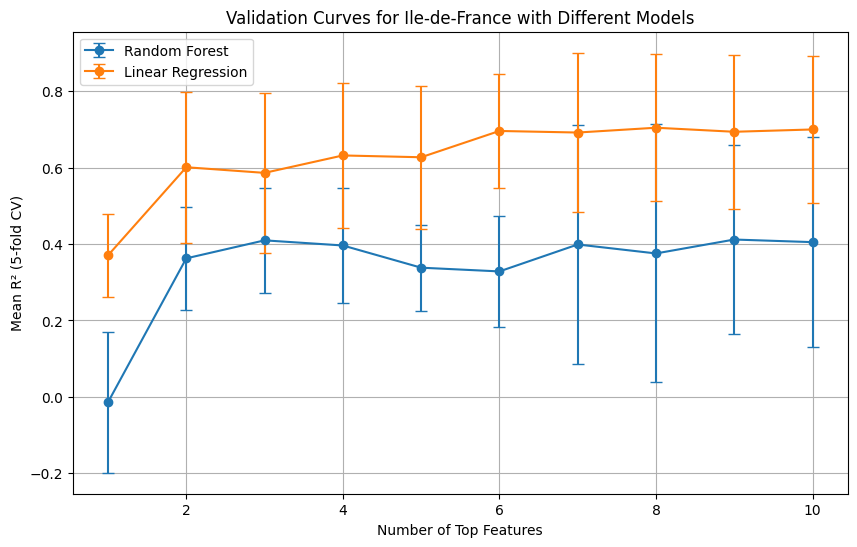

In [153]:
region = "Ile-de-France"
max_features = len(global_rank)  # total number of variables

# Define models to compare
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=4),
    "Linear Regression": LinearRegression(),

}

plt.figure(figsize=(10,6))

# Loop over models
for model_name, model in models.items():
    mean_r2_scores = []
    std_r2_scores  = []

    # Loop over number of top features
    for n_features in range(1, max_features+1):
        top_features = global_rank.sort_values().head(n_features).index.tolist()
        X = X_0[region][top_features].values
        y = y_0[region].values
        if isinstance(y, pd.DataFrame):
            y = y.squeeze()
        else:
            y = np.ravel(y)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
        mean_r2_scores.append(scores.mean())
        std_r2_scores.append(scores.std())

        # Plot with error bars
    plt.errorbar(
        range(1, max_features+1),
        mean_r2_scores,
        yerr=std_r2_scores,
        marker='o',
        capsize=4,
        linewidth=1.5,
        label=model_name
    )

# Plot settings
plt.xlabel("Number of Top Features")
plt.ylabel("Mean R² (5-fold CV)")

plt.title(f"Validation Curves for {region} with Different Models")
plt.legend()
plt.grid(True)
# Save figure (high resolution)
plt.savefig("validation_curves_ile_de_france.png", dpi=300, bbox_inches="tight")
plt.show()

When using Linear Regression we can see a similar pattern, but in this case when we reach the 6th feature we have both the highest mean with smallest variation. Besides, it is very evident that both Ridge and Linear Regression perform way better than Random Forest in this case.

Let's try now to see the behavior in every region, using the two best models: Linear and Ridge Regression.

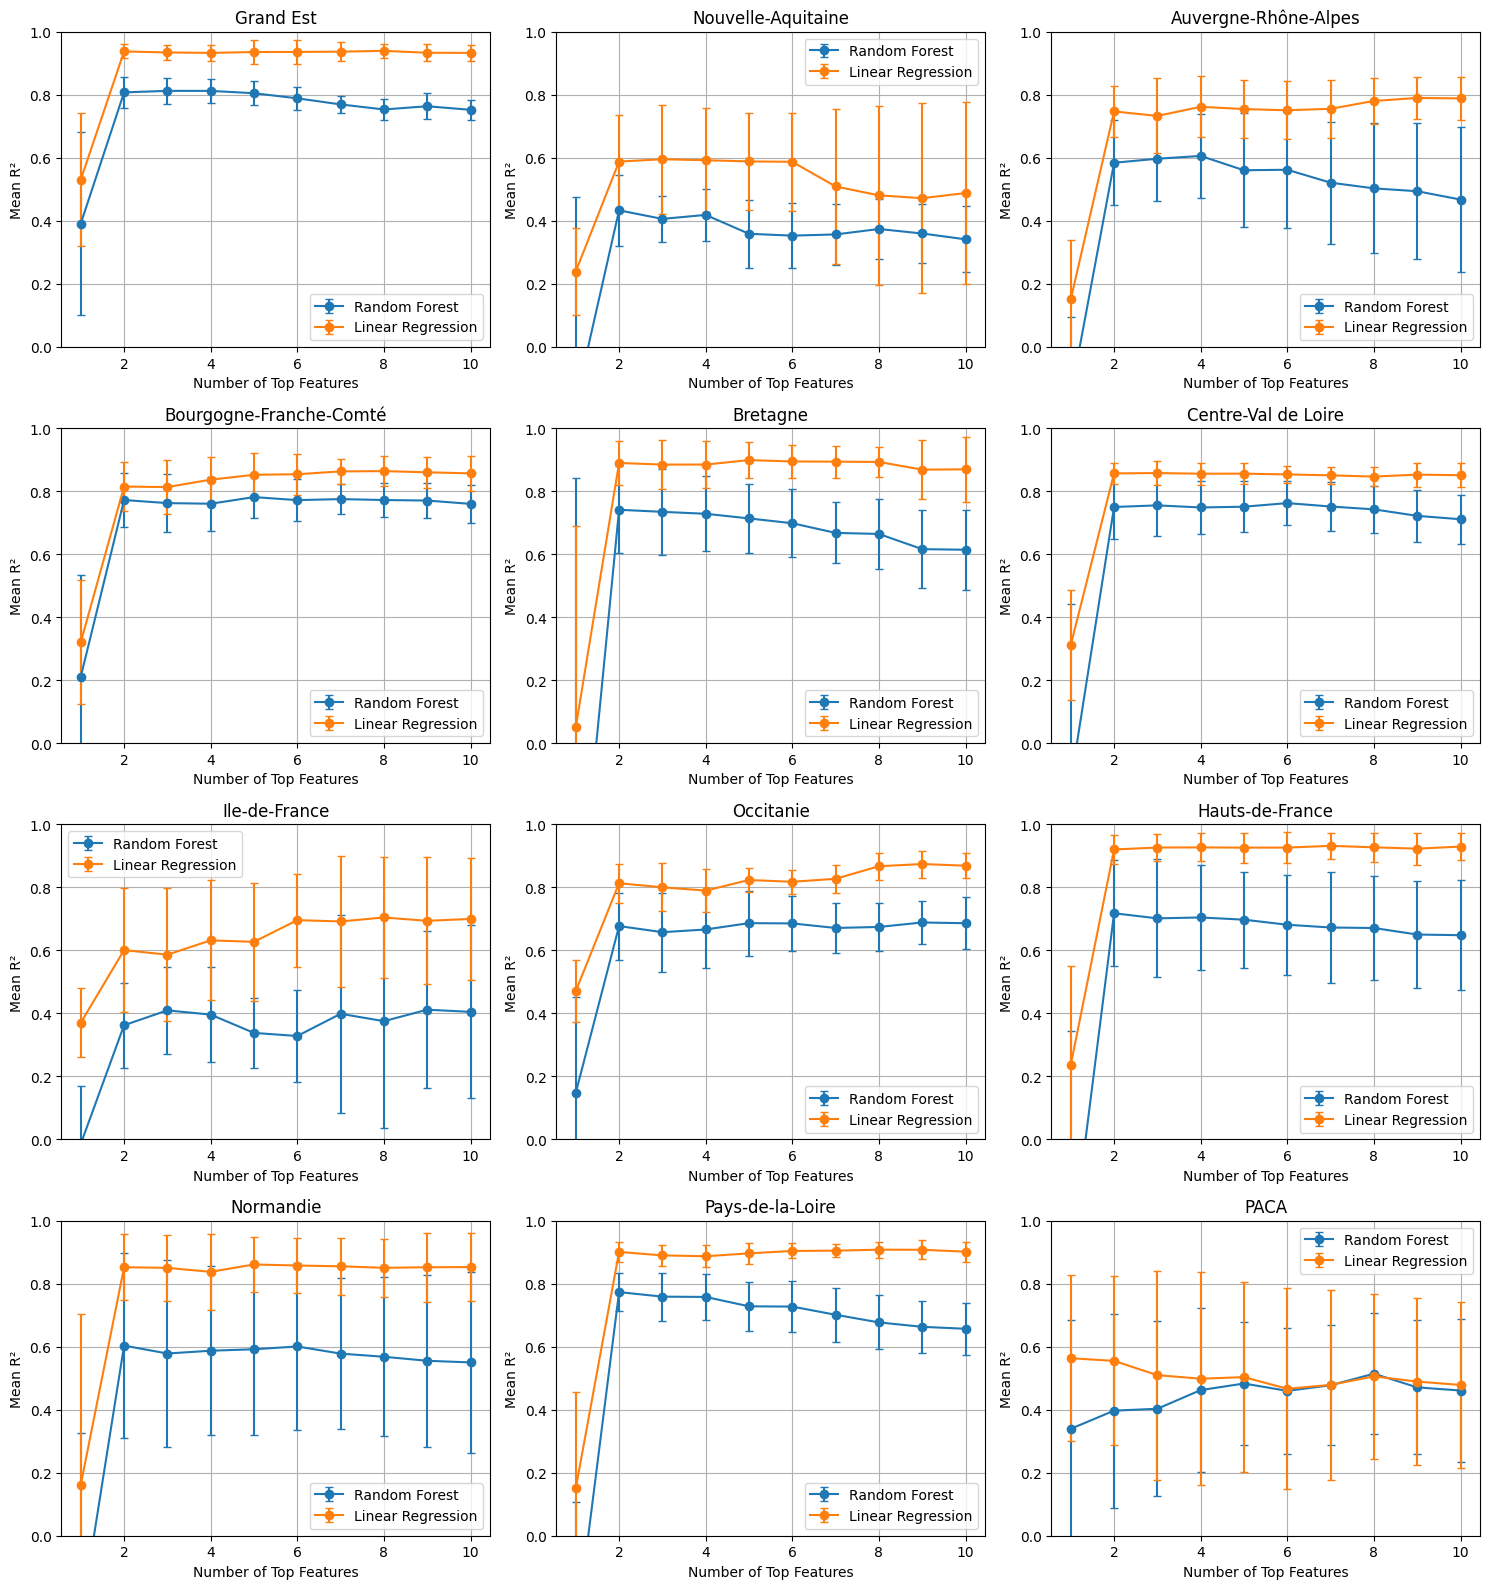

In [155]:
regions = list(X_0.keys())
max_features = len(global_rank)  # total number of variables

# Define models to compare
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=4),
    "Linear Regression": LinearRegression(),
}

# Determine subplot grid size
n_regions = len(regions)
ncols = 3
nrows = (n_regions + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
axes = axes.flatten()  # flatten in case of multiple rows

for i, region in enumerate(regions):
    ax = axes[i]

    # Loop over models
    for model_name, model in models.items():
        mean_r2_scores = []
        std_r2_scores  = []

        # Loop over number of top features
        for n_features in range(1, max_features+1):
            top_features = global_rank.sort_values().head(n_features).index.tolist()

            # Extract X and y for this region
            X_region = X_0[region][top_features].values
            y_region = y_0[region].values

            if isinstance(y, pd.DataFrame):
                y_region = y_region.squeeze()
            else:
                y_region = np.ravel(y_region)

            # 5-fold CV
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(model, X_region, y_region, cv=kf, scoring='r2')
            mean_r2_scores.append(scores.mean())
            std_r2_scores.append(scores.std())
            # Add error bars
        ax.errorbar(
            range(1, max_features + 1),
            mean_r2_scores,
            yerr=std_r2_scores,
            marker='o',
            capsize=3,
            label=model_name
        )

    ax.set_title(region)
    ax.set_xlabel("Number of Top Features")
    ax.set_ylabel("Mean R²")
    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)
    ax.legend()


# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# Save figure (high resolution recommended)
plt.savefig("validation_curves_all_regions.png", dpi=300, bbox_inches="tight")
plt.show()

Let's try to visualize how good are any of the two models explored to predict the monthly capacity factor. We will set up the validation year as 2019 (as if we were in 2018 and wanted to predict for the next year). Then, in the following cell, the number of features, region and model can be chosen.

In [147]:
def _ensure_1d_y(y): #This is to avoid the Warnings from sklearn
    """Ensure y is a 1-D numpy array or pandas Series."""
    if isinstance(y, pd.DataFrame):
        y = y.squeeze()
    return np.ravel(y)


def _get_model_by_name(name, random_state=0):
    """Return an sklearn model from a name."""
    name = name.lower()

    if name == 'random_forest':
        return RandomForestRegressor(
            n_estimators=200,
            random_state=random_state,
            n_jobs=-1
        )

    if name == 'linear':
        return LinearRegression()

    raise ValueError(f"Unknown model name: {name}")

def train_and_validate_region(
    region_name,
    X_dict,
    y_dict,
    ranked_df,
    model_name='random_forest',
    n_features=5,
    random_state=0,
    plot=True,
    return_models=False
):
    """
    Train a model for a region and validate on year 2019,
    using the top-n globally ranked features in ranked_df.

    ranked_df must contain the globally ranked feature list,
    sorted best → worst, with index = feature names.
    """

    # --- 0. Fetch region data
    X = X_dict[region_name].copy()
    y = y_dict[region_name]
    y = pd.Series(_ensure_1d_y(y), index=X.index)

    # --- 1. Split by year 2019
    val_year = 2019
    mask_val = X.index.year == val_year #Verify if the year is equal to the validation year

    X_train = X.loc[~mask_val]
    X_val   = X.loc[mask_val]
    y_train = y.loc[~mask_val]
    y_val   = y.loc[mask_val]

    # --- 2. Select top features from ranked_df
    selected = ranked_df.head(n_features).index.tolist() # Select the top features from the ranked_dy we created with the features
    X_train_sel = X_train[selected]
    X_val_sel   = X_val[selected]

    # --- 3. Create model pipeline
    base_model = _get_model_by_name(model_name, random_state=random_state) #We use the model we want to see
    pipeline = Pipeline([('model', base_model)])

    # --- 4. Fit model
    pipeline.fit(X_train_sel, _ensure_1d_y(y_train))

    # --- 5. Predict on validation
    y_pred = pipeline.predict(X_val_sel) #We predict on the validation set (2019 for our case)
    y_pred = pd.Series(y_pred, index=X_val_sel.index, name='predicted')
    y_true = y_val.copy()
    y_true.name = 'observed'

    # --- 6. Metrics
    r2 = r2_score(y_true, y_pred)

    metrics = {'R2': r2}

    results = {
        'metrics': metrics,
        'y_true': y_true,
        'y_pred': y_pred,
        'selected_features': selected
    }

    # --- 7. Plot & save
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))

        ax.plot(y_true.index, y_true.values, label="Observed (2019)", linewidth=1.5)
        ax.plot(y_pred.index, y_pred.values, label=f"Predicted ({model_name})", linewidth=1.5)

        ax.set_title(
            f"{region_name} — Observed vs Predicted Capacity Factor Anomalities (2019)\n"
            f"Model={model_name}, Top-{len(selected)} Features"
        )
        ax.set_ylabel("Capacity Factor Anomalies")
        ax.grid(alpha=0.3)
        ax.legend()

        plt.tight_layout()
        plt.savefig(
            f"Observed_vs_Predicted_{region_name}.png",
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()
    return results


We can here give as an input the region, number of features and selected model. Using the information from the validation curves, we can have an idea of the amount of features and the selected model that will perform better at predicting the capacity factor for such region.

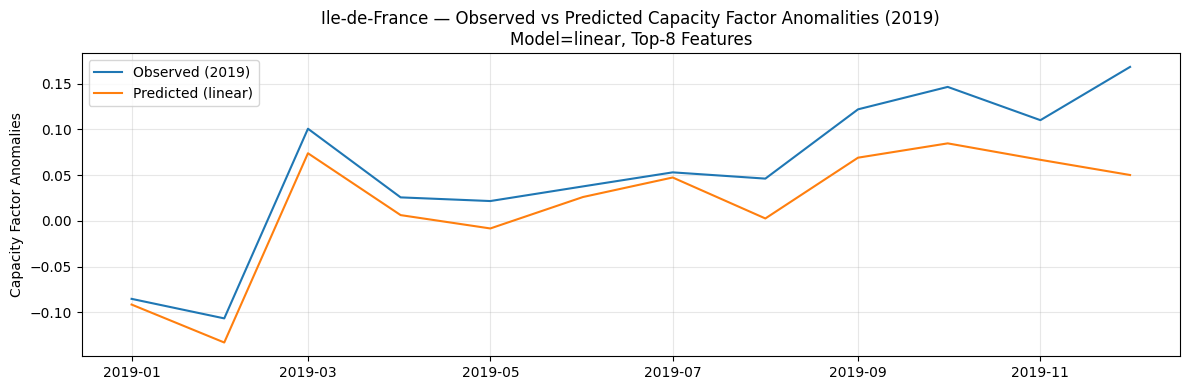

Metrics on 2019 validation:
{'R2': 0.6548694151176744}


<Figure size 640x480 with 0 Axes>

In [148]:
# Example: choose region "Ile-de-France", random forest model, top 6 features,
# rank with 'importance', and show the plot.

region = 'Ile-de-France'
f_selected = 8
model_selected = "linear"
out = train_and_validate_region(
    region_name=region,
    X_dict=X_0,
    y_dict=y_0,
    ranked_df=ranked_df,   # <--- USING YOUR GLOBAL RANKING
    model_name=model_selected,
    n_features = f_selected
)

plt.savefig(f"Observed vs Predicted Capacity Factor{region}.png", dpi=300, bbox_inches="tight")
print("Metrics on 2019 validation:")
print(out['metrics'])


### Steps for Project

1.   Look at data (energy data, weather data, graphs and plots, statistics) J

2.   Clean & Prepare data (remove missing values or outliers, resampling) J

3.   Feature importance --> Feature selection J

4.   GridSearch C

4.   Train model C

5.   Evaluate model C

6.   Draw Conclusions C






##